# Training ResNet20 on CIFAR10

The ResNet is a particularly influential class of neural network architecture for image recognition developed by [Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun](https://arxiv.org/abs/1512.03385). In this notebook we will train one of the smaller ResNets, a ResNet20, on the popular [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) by implementing the One Cycle learning rate policy. The notebook follows [this Keras tutorial](https://keras.io/zh/examples/cifar10_resnet/) very closely, the only difference is that we have swapped out the annealing strategy in that tutorial for the One Cycle strategy. The final results are comparable, reaching 91.87% test set accuracy as opposed to 92.16% in the tutorial and 91.25% in the original paper.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10

from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

plt.style.use('ggplot')
# suppress tensorflow warnings and error messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 500
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

In [3]:
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

print(f'Training model: {model_type}')

Training model: ResNet20v1


In [4]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean
    print('subtracted mean of x_train from x_train and x_test')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

170508288/170498071 [==============================] - 12s 0us/step
subtracted mean of x_train from x_train and x_test
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [5]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_val, y_val = x_train[:5000], y_train[:5000]
x_train, y_train = x_train[5000:], y_train[5000:]

In [6]:
K = tf.keras.backend

class UpdateLrMB(tf.keras.callbacks.Callback):
    def __init__(self,factor,beta=0.98,tolerance = 4,plot_automatic=True,plot_unsmoothed=True):
        self.factor = factor # factor to multiply LR with after every minibatch
        self.beta = beta # 
        self.learning_rate = [] # record lr at every minibatch
        self.loss = [] # loss recorded by TF at end of minibatch. for TF >= 2.2, this is a running average from the beginning of the epoch 
        self.avg_loss = [] # exponentially weighted average of loss
        self.min_loss = np.Inf
        self.current_avg_loss = 0 # at the beginning of training
        self.tolerance = tolerance # the loss can increase to up to tolerance*min_loss
        self.plot_automatic = plot_automatic
        self.plot_unsmoothed = plot_unsmoothed
        self.iteration = 0
    
    def on_train_begin(self,epoch):
        self.current_avg_loss = 0
        self.iteration = 0
    
    def on_batch_end(self,batch,logs): # at the end of first batch, batch=0
        self.iteration += 1
        current_lr = K.get_value(self.model.optimizer.learning_rate)
        current_loss = logs['loss']
        self.current_avg_loss = (self.beta*self.current_avg_loss+(1-self.beta)*current_loss)
        smooth_avg_loss = self.current_avg_loss/(1-self.beta**(self.iteration+1))
        self.min_loss = min(self.min_loss,smooth_avg_loss)
        self.learning_rate.append(current_lr)
        self.loss.append(current_loss)
        self.avg_loss.append(smooth_avg_loss)
        K.set_value(self.model.optimizer.learning_rate,current_lr*self.factor)
        if current_loss >= (self.tolerance * self.min_loss): # stop scanning if exponentially weighted average grows too high
            self.model.stop_training = True
            return
    
    def on_train_end(self,epoch):
        if self.plot_automatic:
            self.plot_lr_vs_loss()
    
    def plot_lr_vs_loss(self,clipstart=10,clipend=1):
        clip = lambda x : x[clipstart:-clipend]
        lr = clip(self.learning_rate)
        avg_loss = clip(self.avg_loss)
        loss = clip(self.loss)
        plt.plot(lr,avg_loss,label='exponentially weighted loss')
        if self.plot_unsmoothed:
            plt.plot(lr,loss,alpha=0.4,label='unsmoothed')
        plt.gca().set_xscale('log')
        minrate = min(self.learning_rate)
        maxrate = max(self.learning_rate)
        minloss = min(self.loss)
        maxloss = self.loss[0]+0.5
        plt.axis([minrate,maxrate,minloss,maxloss])
        plt.xlabel("Learning rate")
        plt.ylabel("Loss")
        plt.legend(loc='best')
        plt.show()

class OneCycle(tf.keras.callbacks.Callback):
    def __init__(self,n_train,batch_size,n_epochs,lr_max,lr_start=None,lr_end=None):
        self.n_train = n_train
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.lr_max = lr_max 
        self.lr_start = lr_start or lr_max/10
        self.lr_end = lr_end or lr_max/1000
        self.num_iter = np.ceil(n_train/batch_size) *n_epochs #total number of iterations
        self.last_iterations = self.num_iter//10 +1 #about last 10 percent of the training iterations
        self.iter_cycle = self.num_iter-self.last_iterations
        self.iter_midpt = self.iter_cycle//2
        self.iteration = 0
        self.current_lr = self.lr_start
        self.lr_record = []
    
    def on_batch_begin(self,epoch,logs):
        lr = self._learning_rate(self.iteration)
        self.iteration += 1
        self.current_lr = lr
        self.lr_record.append(lr)
        K.set_value(self.model.optimizer.learning_rate,lr)
        
    def on_epoch_begin(self,epoch,logs):
        print('learning rate approximately: {:.1e}'.format(self.current_lr))
        
    def _linear_learning_rate(self,x,
                              startx,stopx,
                              starty,stopy):
        return ((stopy-starty)*(x-startx)/(stopx-startx))+starty
    
    def _learning_rate(self,iteration):
        if iteration < self.iter_midpt:
            lr = self._linear_learning_rate(iteration,
                                            0,self.iter_midpt,
                                            self.lr_start,self.lr_max)
        elif iteration < self.iter_cycle:
            lr = self._linear_learning_rate(iteration,
                                            self.iter_midpt,self.iter_cycle,
                                            self.lr_max,self.lr_start)
        else:
            lr = self._linear_learning_rate(iteration,
                                            self.iter_cycle,self.num_iter,
                                            self.lr_start,self.lr_end)
        return lr
    
    def get_lr_record(self):
        return self.lr_record
    
def scan_learning_rate(model,X,y,epochs=1,batch_size=32,minrate=1e-10,maxrate=1):
    model_weights = model.get_weights()
    iterations = np.ceil(len(X)/batch_size)*epochs
    lr_factor = np.exp(np.log(maxrate/minrate)/iterations)
    K.set_value(model.optimizer.learning_rate,minrate)
    lr_update = UpdateLrMB(lr_factor)
    model.fit(X,y,epochs=epochs,batch_size=batch_size,callbacks=[lr_update])
    model.set_weights(model_weights)
    return lr_update

In [7]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [8]:
model = resnet_v1(input_shape=input_shape, depth=depth)

n_epochs = 200
batch_size = 32
validation_split = 0.1

1407/1407 [==============================] - 25s 11ms/step - loss: 6.1782


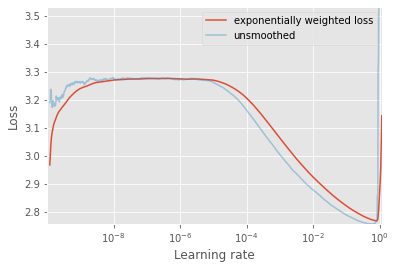

In [9]:
optimizer = Adam()
model.compile(loss='categorical_crossentropy',optimizer=optimizer)
lr_logs= scan_learning_rate(model,x_train,y_train,epochs=1,batch_size=batch_size,minrate=1e-10,maxrate=10)

In [11]:
lr_optimal = 1e-3
lr_start = lr_optimal/10
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_optimal)

metrics = ['accuracy']

model = resnet_v1(input_shape=input_shape, depth=depth)
model.compile(loss='categorical_crossentropy',
              metrics = metrics,
              optimizer=optimizer)
print('model compiled')

model compiled


In [12]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [13]:
# Prepare callbacks for model saving and for learning rate adjustment.

csv_logger =tf.keras.callbacks.CSVLogger('history.csv', separator=",", append=False)

n_train = len(x_train)

lr_scheduler = OneCycle(n_train,
                        batch_size=batch_size,
                        n_epochs=n_epochs,
                        lr_max=lr_optimal)

model_checkpoint_callback = (tf.keras.callbacks.
                             ModelCheckpoint)(filepath=model_name,
                                              save_best_only=True)

callbacks = [model_checkpoint_callback, lr_scheduler,csv_logger]

In [14]:
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_val,y_val),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    
    # Fit the model on the batches generated by datagen.flow().
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_val,y_val),
                        epochs=n_epochs, verbose=1, #workers=4,
                        callbacks=callbacks)

Using real-time data augmentation.
Epoch 1/200
learning rate approximately: 1.0e-04
1407/1407 [==============================] - 38s 25ms/step - loss: 1.9427 - accuracy: 0.3666 - val_loss: 1.6571 - val_accuracy: 0.4510


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
learning rate approximately: 1.1e-04
1407/1407 [==============================] - 35s 25ms/step - loss: 1.5962 - accuracy: 0.4760 - val_loss: 1.4732 - val_accuracy: 0.5246
Epoch 3/200
learning rate approximately: 1.2e-04
1407/1407 [==============================] - 35s 25ms/step - loss: 1.4700 - accuracy: 0.5214 - val_loss: 1.4118 - val_accuracy: 0.5428
Epoch 4/200
learning rate approximately: 1.3e-04
1407/1407 [==============================] - 35s 25ms/step - loss: 1.3762 - accuracy: 0.5614 - val_loss: 1.2699 - val_accuracy: 0.5968
Epoch 5/200
learning rate approximately: 1.4e-04
1407/1407 [==============================] - 35s 25ms/step - loss: 1.2995 - accuracy: 0.5911 - val_loss: 1.2416 - val_accuracy: 0.6092
Epoch 6/200
learning rate approximately: 1.5e-04
1407/1407 [==============================] - 35s 25ms/step - loss: 1.2259 - accuracy: 0.6174 - val_loss: 1.2113 - val_accuracy: 0.6322
Epoch 7/200
learning rate approximately: 1.6e-04
1407/1407 [====================

In [15]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 2s 5ms/step - loss: 0.4482 - accuracy: 0.9187
Test loss: 0.44815894961357117
Test accuracy: 0.9186999797821045


# Visualize One Cycle Learning Rate

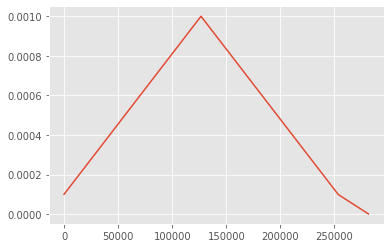

In [16]:
plt.plot(lr_scheduler.get_lr_record())
plt.show()

# Training Curves

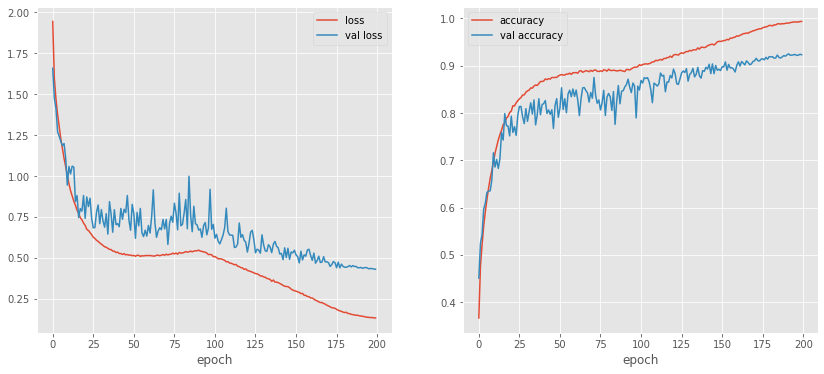

In [17]:
f,ax = plt.subplots(nrows=1,ncols=2,figsize=(14,6))
ax[0].plot(history.history['loss'],label='loss')
ax[0].plot(history.history['val_loss'],label='val loss')
ax[0].set_xlabel('epoch')
ax[0].legend(loc='best')
ax[1].plot(history.history['accuracy'],label='accuracy')
ax[1].plot(history.history['val_accuracy'],label='val accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(loc='best')
plt.show()

In [18]:
np.save('lr_schedule.npy',lr_scheduler.get_lr_record())